<a href="https://colab.research.google.com/github/wmaciek/App_inz/blob/master/1__OCTMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install medmnist

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 87 kB 4.1 MB/s 
  Created wheel for fire: filename=fire-0.4.0-py2.py3-none-any.whl size=115943 sha256=c295f6d1b121def2b12784f4f2dcdd84ab89bf1e88b931228571106ff903a2e2
  Stored in directory: /root/.cache/pip/wheels/8a/67/fb/2e8a12fa16661b9d5af1f654bd199366799740a85c64981226
Successfully built fire


In [ ]:
from tqdm import tqdm
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, WeightedRandomSampler
import torchvision.transforms as transforms
import torch.nn.functional as F
import seaborn as sn
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt


import medmnist
from medmnist import INFO, Evaluator

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


This is 1. notebook for OCTMNIST Dataset (1 canal)<br>
4 clases <br>train: 97477<br>val: 10832<br>test: 1000


In [ ]:
#selecting device
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")

MedMNIST v2.1.0 @ https://github.com/MedMNIST/MedMNIST/


#Loading dataset

In [ ]:
data_flag = 'octmnist'
download = True

NUM_EPOCHS = 100
BATCH_SIZE = 90
lr = 0.0005

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

In [ ]:
# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5],)#,
    #transforms.Grayscale(num_output_channels=1)
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
val_dataset = DataClass(split='val', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)

  0%|          | 0/54938180 [00:00<?, ?it/s]

Using downloaded and verified file: /root/.medmnist/octmnist.npz
Using downloaded and verified file: /root/.medmnist/octmnist.npz


In [ ]:
#Creating sampler

class_weights = np.array([11, 45, 59, 10])
sample_weights = np.array([0] * len(train_dataset))

for i, (data,label) in enumerate(train_dataset):
  class_weight = class_weights[label]
  sample_weights[i] = class_weight

sample_weights = torch.from_numpy(sample_weights)
sampler = WeightedRandomSampler(sample_weights.type('torch.DoubleTensor'), len(sample_weights), replacement=True)

In [ ]:
# encapsulate data into dataloader form
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, sampler=sampler)
val_loader = DataLoader(dataset=val_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
train2_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE)

#Info + samples

In [ ]:
info

{'python_class': 'OCTMNIST',
 'description': 'The OCTMNIST is based on a prior dataset of 109,309 valid optical coherence tomography (OCT) images for retinal diseases. The dataset is comprised of 4 diagnosis categories, leading to a multi-class classification task. We split the source training set with a ratio of 9:1 into training and validation set, and use its source validation set as the test set. The source images are gray-scale, and their sizes are (384−1,536)×(277−512). We center-crop the images and resize them into 1×28×28.',
 'url': 'https://zenodo.org/record/6496656/files/octmnist.npz?download=1',
 'MD5': 'c68d92d5b585d8d81f7112f81e2d0842',
 'task': 'multi-class',
 'label': {'0': 'choroidal neovascularization',
  '1': 'diabetic macular edema',
  '2': 'drusen',
  '3': 'normal'},
 'n_channels': 1,
 'n_samples': {'train': 97477, 'val': 10832, 'test': 1000},
 'license': 'CC BY 4.0'}

In [ ]:
label_array_train = []
for (data, labels) in train_dataset:
  label_array_train.append(labels)
index_values = np.arange(1, len(label_array_train)+1)
column_values = ['class']
  
# creating the train dataframe
df_train = pd.DataFrame(data = label_array_train, 
                  index = index_values, 
                  columns = column_values)

label_array_val = []
for (data, labels) in val_dataset:
  label_array_val.append(labels)
index_values = np.arange(1, len(label_array_val)+1)
column_values = ['class']
  
# creating the val dataframe
df_val = pd.DataFrame(data = label_array_val, 
                  index = index_values, 
                  columns = column_values)

label_array_test = []
for (data, labels) in test_dataset:
  label_array_test.append(labels)
index_values = np.arange(1, len(label_array_test)+1)
column_values = ['class']
  
# creating the test dataframe
df_test = pd.DataFrame(data = label_array_test, 
                  index = index_values, 
                  columns = column_values)

In [ ]:
train_size_arange = np.arange(1, len(label_array_train)+1)
train_1 = sum(df_train["class"]==1)
train_0 = sum(df_train["class"]==0)
train_2 = sum(df_train["class"]==2)
train_3 = sum(df_train["class"]==3)

val_size_arange = np.arange(1, len(label_array_val)+1)
val_1 = sum(df_val["class"]==1)
val_0 = sum(df_val["class"]==0)
val_2 = sum(df_val["class"]==2)
val_3 = sum(df_val["class"]==3)

test_size_arange = np.arange(1, len(label_array_test)+1)
test_1 = sum(df_test["class"]==1)
test_0 = sum(df_test["class"]==0)
test_2 = sum(df_test["class"]==2)
test_3 = sum(df_test["class"]==3)

In [ ]:
import plotly.graph_objects as go
sets=['Zbiór Testowy', 'Zbiór Sprawdzający', 'Zbiór Testujący']
fig = go.Figure(data=[
    go.Bar(name='Neowaskularyzacja naczyniówkowa', x=sets, y=[train_0, val_0, test_0]),
    go.Bar(name='Nukrzycowy obrzęk plamki', x=sets, y=[train_1, val_1, test_1]),
    go.Bar(name='Druzy tarczy nerwu wzrokowego', x=sets, y=[train_2, val_2, test_2]),
    go.Bar(name='Zdrowe oko', x=sets, y=[train_3, val_3, test_3])
    ]
    )
fig.update_layout(title="Ilości próbek w zbiorach", width=600, height=300,
                  margin=dict(l=00, r=20, b=30, t=40, pad=10),
                  legend=dict(yanchor="top",xanchor="right"))

fig.update_yaxes(title_text='Ilość')
fig.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning:

The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.

100%|██████████| 97477/97477 [00:20<00:00, 4657.57it/s]


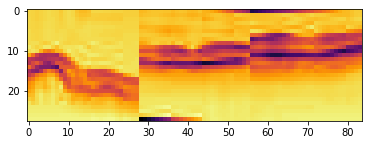

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
tr_l = np.array(train_dataset)
tr_l.shape
data_frame = pd.DataFrame()
img = []
for inputs, targets in tqdm(train_dataset):
  img.append(inputs)
  
sample_pics = [img]
pic1 = img[0].reshape(28,-1)
pic2 = img[1].reshape(28,-1)
pic3 = img[2].reshape(28,-1)
plt.imshow(np.hstack((pic1,pic2, pic3)), cmap="inferno_r")

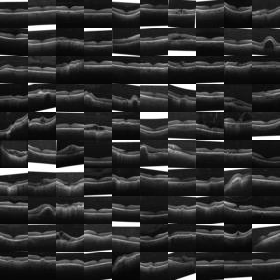

In [ ]:
#or using montage
train_dataset.montage(length=10)

**1) Real OCT of iris**

<img src="https://drive.google.com/uc?export=view&id=1wdjFPgPLHAHHH4AcRc4tv4opC5bBtuIK" width=450></img>

#Training and testing

In [ ]:
# an old model class for pneumonia prediction
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 20, 3, 1)
        self.conv1_bn = nn.BatchNorm2d(20)

        self.conv2 = nn.Conv2d(20, 40, 3, 1)
        self.conv2_bn = nn.BatchNorm2d(40)

        self.conv3 = nn.Conv2d(40, 80, 3, 1)
        self.conv3_bn = nn.BatchNorm2d(80)

        self.conv4 = nn.Conv2d(80, 160, 3, 1)
        self.conv4_bn = nn.BatchNorm2d(160)

        self.fc1 = nn.Linear(7*7*160, 1000) #((((28-2)/2)-2)/2) = 5,..
        self.fc1_bn = nn.BatchNorm1d(1000)

        self.fc2 = nn.Linear(1000, 500)
        self.fc2_bn = nn.BatchNorm1d(500)

        self.fc3 = nn.Linear(500, 50)
        self.fc3_bn = nn.BatchNorm1d(50)

        self.fc4 = nn.Linear(50, 4) #change


    def forward(self, X):
        X = self.conv1(X)
        X = F.relu(self.conv1_bn(X))  #1

        X = F.max_pool2d(X, 2, 2)

        X = self.conv2(X)
        X = F.relu(self.conv2_bn(X))

        X = self.conv3(X)
        X = F.relu(self.conv3_bn(X))  #3

        X = self.conv4(X)
        X = F.relu(self.conv4_bn(X))  #4

        X = X.view(-1, 7*7*160)

        X = self.fc1(X)
        X = F.relu(self.fc1_bn(X))
        X = self.fc2(X)
        X = F.relu(self.fc2_bn(X))
        X = self.fc3(X)
        X = F.relu(self.fc3_bn(X))
        X = self.fc4(X)
        return F.softmax(X, dim=1)

In [ ]:
#Loading model from pneumonia classification
model_oct = ConvolutionalNetwork()
model_oct.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/Med_MNIST_inż/model_pneumonia_91_the_best.pth'))
model_oct.eval()

ConvolutionalNetwork(
  (conv1): Conv2d(1, 20, kernel_size=(3, 3), stride=(1, 1))
  (conv1_bn): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(20, 40, kernel_size=(3, 3), stride=(1, 1))
  (conv2_bn): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(40, 80, kernel_size=(3, 3), stride=(1, 1))
  (conv3_bn): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(80, 160, kernel_size=(3, 3), stride=(1, 1))
  (conv4_bn): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=7840, out_features=1000, bias=True)
  (fc1_bn): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=1000, out_features=500, bias=True)
  (fc2_bn): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=500, out_featur

In [ ]:
#Freezing all of the params to train only output layer
for param in model_oct.parameters():
  param.requires_grad = False  #false for freeze

In [ ]:
#Changing the last fc layer to adopt it to the new model
n_in_features = model_oct.fc4.in_features  #Getting in features from fc4(last layer)
model_oct.fc4 = nn.Linear(n_in_features, n_classes)  #Changing fc4 to meet our demands
model_oct.to(device)

loss_function = nn.CrossEntropyLoss() #for multiclass.
optimizer = torch.optim.Adam(model_oct.parameters(), lr=0.0005)
model_oct

ConvolutionalNetwork(
  (conv1): Conv2d(1, 20, kernel_size=(3, 3), stride=(1, 1))
  (conv1_bn): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(20, 40, kernel_size=(3, 3), stride=(1, 1))
  (conv2_bn): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(40, 80, kernel_size=(3, 3), stride=(1, 1))
  (conv3_bn): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(80, 160, kernel_size=(3, 3), stride=(1, 1))
  (conv4_bn): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=7840, out_features=1000, bias=True)
  (fc1_bn): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=1000, out_features=500, bias=True)
  (fc2_bn): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=500, out_featur

In [ ]:
def get_accuracy(model, test_loader):
  correct = 0
  total = 0
  with torch.no_grad():
      for (data, labels) in test_loader:
          net_out = model(data.to(device)) 
          predicted_labels = []
          for row in net_out:
            predicted_labels.append(torch.argmax(row).to(device))

          for i, object in enumerate(predicted_labels):
              if predicted_labels[i].to(device) == labels[i].to(device):
                correct += 1
              total += 1
  return correct/total

In [ ]:
from tqdm.notebook import tqdm
min_valid_loss = np.inf
best_both = 0
MODELPATHAGE = "/content/drive/MyDrive/Colab Notebooks/Med_MNIST_inż/model_oct.pth"

historical_train_loss = []
historical_validation_loss = []
epochs = []
i = 0
best_acc = 0

for epoch in range(NUM_EPOCHS):
  
  train_loss = 0.0

#  TRAINING
  for (data, labels) in tqdm(train_loader):
    labels_1hot_t = []
    optimizer.zero_grad()  #cleaning previous gradients
    target = model_oct(data.to(device))  #foreward pass
    for l in labels:
      labels_1hot_t.append(np.eye(n_classes)[l])
    loss = loss_function(target.to(device), torch.Tensor(labels_1hot_t).to(device))
    loss.backward()  #backward pass
    optimizer.step()  #updating weights
    train_loss += loss.item()
    histloss = loss
    i+=1

#  VALIDATION
  validation_loss = 0.0
  model_oct.eval() 

  for (data, labels) in val_loader:
    labels_1hot_v = []
    target = model_oct(data.to(device))  #foreward pass
    for l in labels:
      labels_1hot_v.append(np.eye(n_classes)[l])
    loss = loss_function(target.to(device), torch.Tensor(labels_1hot_v).to(device))
    validation_loss += loss.item()
    hisvloss = loss

  historical_train_loss.append(histloss)
  historical_validation_loss.append(hisvloss)

#  TESTING
  y_pred = []
  y_true = []
  with torch.no_grad():
    for (data, labels) in test_loader:
        net_out = model_oct(data.to(device))
        for row in net_out:
          y_pred.append(torch.argmax(row.cpu()).numpy()) # Save Prediction
        for row in labels:
          y_true.append(row.data.cpu().numpy()) # Save Truth

  p_s = 45 * precision_score(y_true, y_pred, average='weighted', zero_division="warn")
  acc = 55 * get_accuracy(model_oct, test_loader)


  if p_s*acc > best_both:
    best_both = p_s*acc
    model_oct.to(device)
    torch.save(model_oct.state_dict(), MODELPATHAGE)
    print('model Saved')

  epochs.append(epoch+1)

  print(f'Epoch {epoch + 1}.\n\
  Training loss: {round(train_loss/len(train_loader),4)}\n\
  Validation loss: {round(validation_loss/len(val_loader),4)}\n\
  Accuracy over test data: {round(acc*100/55,4)}%\n\
  Precission over test data: {round(p_s/45,3)}\n')

In [ ]:
a = [ loss.cpu().detach().numpy() for loss in historical_train_loss]
b = [ loss.cpu().detach().numpy() for loss in historical_validation_loss]
t  = np.arange(1, NUM_EPOCHS+1)

In [ ]:
import plotly.graph_objects as go
sets=['Train Dataset', 'Val Dataset', 'Test Dataset']
fig = go.Figure(data=[
    go.Line(name='Train loss', x=t, y=a),
    go.Line(name='Val loss', x=t, y=b)]
    )
fig.update_layout(title="Loss over epochs", width=600, height=300,
                  margin=dict(l=00, r=20, b=30, t=40, pad=10),
                  legend=dict(yanchor="top",xanchor="right"))
fig.update_xaxes(title_text='Epoch')
fig.update_yaxes(title_text='BCEloss')
fig.show()

/usr/local/lib/python3.7/dist-packages/plotly/graph_objs/_deprecations.py:385: DeprecationWarning: plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.

  DeprecationWarning,


#Testing saved model

In [ ]:
model_oct = ConvolutionalNetwork()
model_oct.to(device)
model_oct.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/Med_MNIST_inż/model_oct_77.pth'))
model_oct.eval()

ConvolutionalNetwork(
  (conv1): Conv2d(1, 20, kernel_size=(3, 3), stride=(1, 1))
  (conv1_bn): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(20, 40, kernel_size=(3, 3), stride=(1, 1))
  (conv2_bn): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(40, 80, kernel_size=(3, 3), stride=(1, 1))
  (conv3_bn): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(80, 160, kernel_size=(3, 3), stride=(1, 1))
  (conv4_bn): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=7840, out_features=1000, bias=True)
  (fc1_bn): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=1000, out_features=500, bias=True)
  (fc2_bn): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=500, out_featur

In [ ]:
acc_train = get_accuracy(model_oct, train2_loader)
acc_val = get_accuracy(model_oct, val_loader)
acc_test = get_accuracy(model_oct, test_loader)

print(f'Accuracy:\n-train: {acc_train}\n-val: {acc_val}\n-test: {acc_test}')

Accuracy:
-train: 0.8130328179980919
-val: 0.7998522895125554
-test: 0.76


In [ ]:
print(f'Ac_0={229/(229+18+3)}, Ac_1={206/(206+33+11)},\
Ac_2={132/(132+69+13+36)}, Ac_3={193/(193+13+13)}')

Ac_0=0.916, Ac_1=0.824,Ac_2=0.528, Ac_3=0.8812785388127854


In [ ]:
y_pred = []
y_true = []
# iterate over test data
with torch.no_grad():
  for (data, labels) in test_loader:
        net_out = model_oct(data.to(device))
        for row in net_out:
          y_pred.append(torch.argmax(row.cpu()).numpy()) # Save Prediction
        for row in labels:
          y_true.append(row.data.cpu().numpy()) # Save Truth

array([[229,  18,   3,   0],
       [ 33, 206,   4,   7],
       [ 69,  13, 132,  36],
       [  7,   7,  43, 193]])

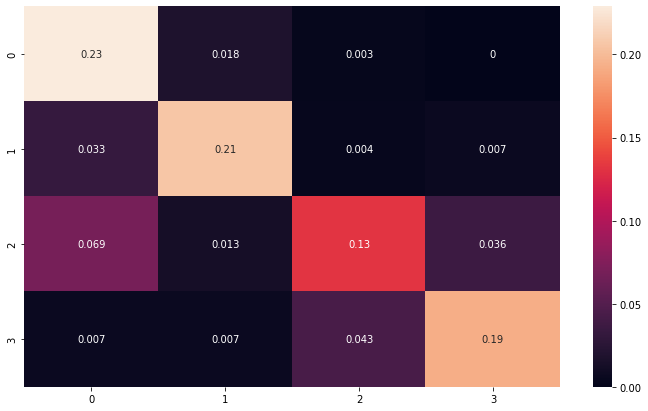

In [ ]:
#confusion
# constant for classes
classes = ('0', '1', '2', '3')
# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/len(y_true), index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')
cf_matrix

In [ ]:
#precission
p_s = precision_score(y_true, y_pred, average='weighted')
#recall
r_s = recall_score(y_true, y_pred, average='weighted')
#f1 score
f1_s = f1_score(y_true, y_pred, average='weighted')

In [ ]:
print(f'Precision score: {p_s}\nRecall score: {r_s}\nf1 score: {f1_s}')

Precision score: 0.7662121058563981
Recall score: 0.76
f1 score: 0.7545673640076314


#Single sample prediction

In [ ]:
def predict(model, image):
    with torch.no_grad():
        net_out = model(image)  # returns a list,
        predicted_class = torch.argmax(net_out)
        print('net_out: ', net_out)
    return predicted_class.item()

In [ ]:
images_0 = []
for (data,label) in test_dataset:
  if label == 0:
    images_0.append(data)

images_1 = []
for (data,label) in test_dataset:
  if label == 1:
    images_1.append(data)

images_2 = []
for (data,label) in test_dataset:
  if label == 2:
    images_2.append(data)

images_3 = []
for (data,label) in test_dataset:
  if label == 3:
    images_3.append(data)

print(len(images_0), len(images_1), len(images_2), len(images_3))

250 250 250 250


In [ ]:
model_oct.to('cpu')

ConvolutionalNetwork(
  (conv1): Conv2d(1, 20, kernel_size=(3, 3), stride=(1, 1))
  (conv1_bn): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(20, 40, kernel_size=(3, 3), stride=(1, 1))
  (conv2_bn): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(40, 80, kernel_size=(3, 3), stride=(1, 1))
  (conv3_bn): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(80, 160, kernel_size=(3, 3), stride=(1, 1))
  (conv4_bn): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=7840, out_features=1000, bias=True)
  (fc1_bn): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=1000, out_features=500, bias=True)
  (fc2_bn): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=500, out_featur

In [ ]:
img_oct_0 = images_0[0].reshape(1,1,28,28)
predicted =  predict(model_oct, torch.Tensor(img_oct_0))
predicted

net_out:  tensor([[1.0000e+00, 4.7479e-23, 3.4503e-18, 6.1219e-35]])


0

In [ ]:
img_oct_1 = images_1[0].reshape(1,1,28,28)
predicted =  predict(model_oct, torch.Tensor(img_oct_1))
predicted

net_out:  tensor([[1.3896e-08, 1.0000e+00, 7.7762e-10, 1.2421e-10]])


1

In [ ]:
img_oct_2 = images_2[0].reshape(1,1,28,28)
predicted =  predict(model_oct, torch.Tensor(img_oct_2))
predicted

net_out:  tensor([[1.3343e-04, 8.3392e-07, 9.9986e-01, 4.0567e-06]])


2

In [ ]:
img_oct_3 = images_3[0].reshape(1,1,28,28)
predicted =  predict(model_oct, torch.Tensor(img_oct_3))
predicted

net_out:  tensor([[3.0063e-06, 7.6600e-05, 2.4117e-03, 9.9751e-01]])


3

In [ ]:
np.save("/content/drive/MyDrive/Colab Notebooks/Med_MNIST_inż/img_oct_0_p.npy",
        img_oct_0 )
np.save("/content/drive/MyDrive/Colab Notebooks/Med_MNIST_inż/img_oct_1_p.npy",
        img_oct_1 )
np.save("/content/drive/MyDrive/Colab Notebooks/Med_MNIST_inż/img_oct_2_p.npy",
        img_oct_2 )
np.save("/content/drive/MyDrive/Colab Notebooks/Med_MNIST_inż/img_oct_3_P.npy",
        img_oct_3 )